# Breaking Point: Analyzing the Effect of Injuries on NBA Team Performance

We have always been facinated by the unperdictable nature of sports, how even a championship level team can unravel due to a single injury. That lead us to explore how injury trends in the NBA affect team performance. Using multiple datasets with decades of inputs, this project investigates the correlations between win-loss ratios, postseason sucess, and strength of schedule with injuries. Through this analysis, we hope to answer the following questions:

- How do injury counts per season correlate with a team's win to loss ratio in the NBA?
- Do teams with fewer injuries consistently rank higher in their conferences or make deeper playoff runs?
- Do teams with stronger strength of schedule suffer more injuries throughout the season?

## Challenge Goals

Multiple Data Sets
* 

Statistical Hypothesis Testing
* 

*Replace this text with your challenge goals. If the challenge goals were scaled back or expanded, explain why the task turned out differently than initially estimated.*

## Collaboration and Conduct

Students are expected to follow Washington state law on the [Student Conduct Code for the University of Washington](https://www.washington.edu/admin/rules/policies/WAC/478-121TOC.html). In this course, students must:

- Indicate on your submission any assistance received, including materials distributed in this course.
- Not receive, generate, or otherwise acquire any substantial portion or walkthrough to an assessment.
- Not aid, assist, attempt, or tolerate prohibited academic conduct in others.

Update the following code cell to include your name and list your sources. If you used any kind of computer technology to help prepare your assessment submission, include the queries and/or prompts. Submitted work that is not consistent with sources may be subject to the student conduct process.

In [ ]:
your_name = "Nadira Haddach and Ethan Tran"
sources = [
"Hypothesis Testing source: https://github.com/eceisik/eip/blob/main/hypothesis_testing_examples.ipynb",
"Pearson Testing source: https://www.tutorialspoint.com/show-pearson-correlation-test-between-two-variables-using-python",
"https://courses.cs.washington.edu/courses/cse163/25sp/2025/04/04/strings-and-lists/",
"https://www.geeksforgeeks.org/python-pandas-dataframe-isin/",
"https://courses.cs.washington.edu/courses/cse163/25sp/2025/04/09/data-structures/",
"https://courses.cs.washington.edu/courses/cse163/25sp/2025/04/21/data-visualization/",
"https://courses.cs.washington.edu/courses/cse163/25sp/2025/04/16/groupby-and-indexing/",
"


]

assert your_name != "", "your_name cannot be empty"
assert ... not in sources, "sources should not include the placeholder ellipsis"
assert len(sources) >= 6, "must include at least 6 sources, inclusive of lectures and sections"

AssertionError: must include at least 6 sources, inclusive of lectures and sections

## Data Setting and Methods

#### Data Setting


#### Methods

*Replace this text with a description of the data setting, any data transformations you conducted, and the methods you plan to use to answer the research questions. You may remove the code cell below if you don't need it.*

In [ ]:
!pip install plotly
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy import stats
from scipy.stats import pearsonr

  Using cached plotly-6.1.2-py3-none-any.whl.metadata (6.9 kB)
  Using cached narwhals-1.42.0-py3-none-any.whl.metadata (11 kB)
Using cached plotly-6.1.2-py3-none-any.whl (16.3 MB)
Using cached narwhals-1.42.0-py3-none-any.whl (359 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


**The following code is to load and clean data:**

In [5]:
# Step 1: Load and Clean Data
def load_injury_data(filepath):
    '''
    Takes in filepath (str) to injury data and returns cleaned DataFrame.
    '''
    df = pd.read_csv(filepath)
    df['Player'] = df['Relinquished']
    df['Injury'] = df['Notes']
    df = df[['Player', 'Team', 'Date', 'Injury']]
    df['Season'] = [int(date[:4]) for date in df['Date']]
    
    return df

def load_team_stats(filepath):
    '''
    Takes in filepath (str) to injury data and returns cleaned DataFrame.
    '''
    df = pd.read_csv(filepath)
    df = df[['Team', 'Season', 'W/L%', 'Playoffs']] 
    df['Season'] = [int(season[:4]) for season in df['Season']]
    
    return df

def load_team_performance(filepath):
    '''
    Takes in filepath (str) to advanced stats data and returns cleaned DataFrame.
    '''
    df = pd.read_csv(filepath)
    df = df[['Team', 'Year', 'Pace', 'OPtg', 'DRtg', 'SOS']]
    df['Season'] = df['Year']
    df = df.drop(columns=['Year'])
    
    return df

def compute_injury_counts_by_team_year(filepath):
    '''
    Loads NBA injury data and returns a DataFrame showing injury counts per team per year.
    '''
    df = pd.read_csv(filepath)
    df = df[['Date', 'Team', 'Relinquished']]
    df = df[[type(date) != float and type(team) != float for date, team in zip(df['Date'], df['Team'])]]
    df['Year'] = [int(date[:4]) for date in df['Date']]
    injury_counts = df.groupby(['Team', 'Year']).size().reset_index(name='Injury_Count')

    return injury_counts

# Load Data
injuries_df = load_injury_data('data/nba_injuries.csv')
team_stats = load_team_stats('data/Team_Records.csv')
team_perf = load_team_performance('data/advanced_stats_total.csv')
injury_counts = compute_injury_counts_by_team_year("data/nba_injuries.csv")

bad_teams = [
    'Colonels (ABA)', 'Squires (ABA)', 'Chaparrals (ABA)', 'Tams (ABA)',
    'Nets (ABA)', 'Spirits (ABA)', 'Stars (ABA)', 'Nuggets (ABA)'
]

bad_teams_stats = [
    'Texas Chaparrals*',
    'Dallas Chaparrals',
    'Dallas Chaparrals*'
]

# Remove bad rows:
injuries_df = injuries_df[~injuries_df['Team'].isin(bad_teams)]

team_stats = team_stats[~team_stats['Team'].isin(bad_teams_stats)]

#Strip whitespace
injuries_df['Team'] = injuries_df['Team'].str.strip()
team_stats['Team'] = team_stats['Team'].str.strip()


**The following code standardizes team names by mapping full team names to shortened names and legacy teams to their modern counterpart:**

In [6]:
team_name_mapping = {
    '76ers': 'Philadelphia 76ers',
    'Bucks': 'Milwaukee Bucks',
    'Bulls': 'Chicago Bulls',
    'Cavaliers': 'Cleveland Cavaliers',
    'Celtics': 'Boston Celtics',
    'Clippers': 'Los Angeles Clippers',
    'Grizzlies': 'Memphis Grizzlies',
    'Hawks': 'Atlanta Hawks',
    'Heat': 'Miami Heat',
    'Hornets': 'Charlotte Hornets',
    'Jazz': 'Utah Jazz',
    'Kings': 'Sacramento Kings',
    'Knicks': 'New York Knicks',
    'Lakers': 'Los Angeles Lakers',
    'Magic': 'Orlando Magic',
    'Mavericks': 'Dallas Mavericks',
    'Nets': 'Brooklyn Nets',
    'Nuggets': 'Denver Nuggets',
    'Pacers': 'Indiana Pacers',
    'Pelicans': 'New Orleans Pelicans',
    'Pistons': 'Detroit Pistons',
    'Raptors': 'Toronto Raptors',
    'Rockets': 'Houston Rockets',
    'Spurs': 'San Antonio Spurs',
    'Suns': 'Phoenix Suns',
    'Thunder': 'Oklahoma City Thunder',
    'Timberwolves': 'Minnesota Timberwolves',
    'Trail Blazers': 'Portland Trail Blazers',
    'Warriors': 'Golden State Warriors',
    'Wizards': 'Washington Wizards',
    
    # Historical mappings
    'Atlanta Hawks*': 'Atlanta Hawks',
    'Boston Celtics*': 'Boston Celtics',
    'Brooklyn Nets*': 'Brooklyn Nets',
    'Charlotte Hornets*': 'Charlotte Hornets',
    'Chicago Bulls*': 'Chicago Bulls',
    'Cleveland Cavaliers*': 'Cleveland Cavaliers',
    'Dallas Mavericks*': 'Dallas Mavericks',
    'Denver Nuggets*': 'Denver Nuggets',
    'Detroit Pistons*': 'Detroit Pistons',
    'Golden State Warriors*': 'Golden State Warriors',
    'Houston Rockets*': 'Houston Rockets',
    'Indiana Pacers*': 'Indiana Pacers',
    'Los Angeles Clippers*': 'Los Angeles Clippers',
    'Los Angeles Lakers*': 'Los Angeles Lakers',
    'Memphis Grizzlies*': 'Memphis Grizzlies',
    'Miami Heat*': 'Miami Heat',
    'Milwaukee Bucks*': 'Milwaukee Bucks',
    'Minnesota Timberwolves*': 'Minnesota Timberwolves',
    'New Orleans Pelicans*': 'New Orleans Pelicans',
    'New York Knicks*': 'New York Knicks',
    'Oklahoma City Thunder*': 'Oklahoma City Thunder',
    'Orlando Magic*': 'Orlando Magic',
    'Philadelphia 76ers*': 'Philadelphia 76ers',
    'Phoenix Suns*': 'Phoenix Suns',
    'Portland Trail Blazers*': 'Portland Trail Blazers',
    'Sacramento Kings*': 'Sacramento Kings',
    'San Antonio Spurs*': 'San Antonio Spurs',
    'Toronto Raptors*': 'Toronto Raptors',
    'Utah Jazz*': 'Utah Jazz',
    'Washington Wizards*': 'Washington Wizards',
    
    # Legacy / old franchise names
    'Zephyrs': 'Washington Wizards',
    'Rochester Royals': 'Sacramento Kings',
    'Tri-Cities Blackhawks': 'Atlanta Hawks',
    'Chicago Packers': 'Washington Wizards',
    'San Francisco Warriors': 'Golden State Warriors',
    'Syracuse Nationals': 'Philadelphia 76ers',
    'New Jersey Americans': 'Brooklyn Nets',
    'Denver Rockets': 'Denver Nuggets',
    'Capital Bullets': 'Washington Wizards',
    'Chicago Zephyrs': 'Washington Wizards',
    'San Diego Rockets': 'Houston Rockets',
    'Baltimore Bullets': 'Washington Wizards',
    'Baltimore Bullets*': 'Washington Wizards',
    'Bullets': 'Washington Wizards',
    'New Jersey Nets': 'Brooklyn Nets',
    'New Orleans Hornets': 'New Orleans Pelicans',
    'New Orleans/Oklahoma City Hornets': 'New Orleans Pelicans',
    'Seattle SuperSonics': 'Oklahoma City Thunder',
    'San Diego Clippers': 'Los Angeles Clippers',
    'Vancouver Grizzlies': 'Memphis Grizzlies',
    'Charlotte Bobcats': 'Charlotte Hornets',
    'New Orleans Jazz': 'Utah Jazz',
    'Kansas City Kings': 'Sacramento Kings',
    'Cincinnati Royals': 'Sacramento Kings',
    'St. Louis Hawks': 'Atlanta Hawks',
    'Washington Bullets': 'Washington Wizards',
    'Fort Wayne Pistons': 'Detroit Pistons',
    'Minneapolis Lakers': 'Los Angeles Lakers',
    'Buffalo Braves': 'Los Angeles Clippers',
    'Braves': 'Los Angeles Clippers',
    'Bobcats': 'Charlotte Hornets',
    'Blazers': 'Portland Trail Blazers',
    'Philadelphia Warriors': 'Golden State Warriors',
    'Kansas City-Omaha Kings': 'Sacramento Kings',
    'Milwaukee Hawks': 'Atlanta Hawks'
}

# Standardize the team names
injuries_df['Team'] = injuries_df['Team'].map(team_name_mapping)
team_stats['Team'] = team_stats['Team'].map(team_name_mapping)
team_perf['Team'] = team_perf['Team'].map(team_name_mapping)
injury_counts['Team'] = injury_counts['Team'].map(team_name_mapping)

# Drop rows with missing Team (but keep the full DataFrame)
injuries_df.dropna(subset=['Team'], inplace=True)
team_stats.dropna(subset=['Team'], inplace=True)
team_perf.dropna(subset=['Team'], inplace=True)
injury_counts.dropna(subset=['Team'], inplace=True)

**The following code merges the datasets:**

In [7]:
# Step 2: Merge Datasets
def merge_datasets(injuries_df, stats_df, bench_df):
    '''
    Takes in injuries DataFrame, stats DataFrame, and bench DataFrame as strings and reutrns merged
    DataFrame.
    '''
    injuries_count = injuries_df.groupby(['Team', 'Season']).size().reset_index(name='Injury_Count')
    merged = stats_df.merge(injuries_count, on=['Team', 'Season'], how='left')
    merged = merged.merge(bench_df, on=['Team', 'Season'], how='left')
    
    stats_df['Season'] = [int(season) for season in stats_df['Season']]
    
    merged = merged.merge(injury_counts, left_on=['Team', 'Season'], right_on=['Team', 'Year'], how='left')
    
    return merged

merged_df = merge_datasets(injuries_df, team_stats, team_perf)

## Results

### 1. How do injury counts per season correlate with a team's win to loss ratio in the NBA?

To explore this question, we approached the data in two primary ways: visual trend analysis and statistical testing.

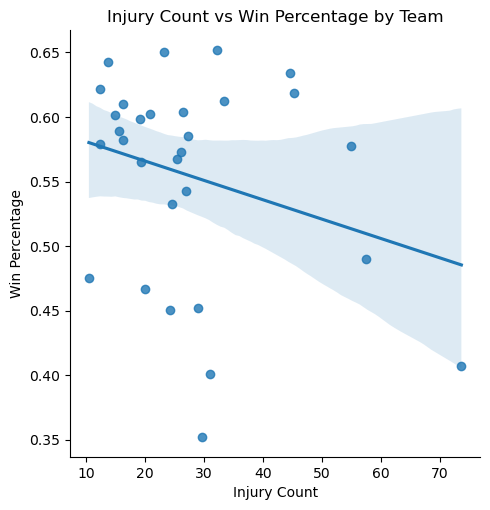

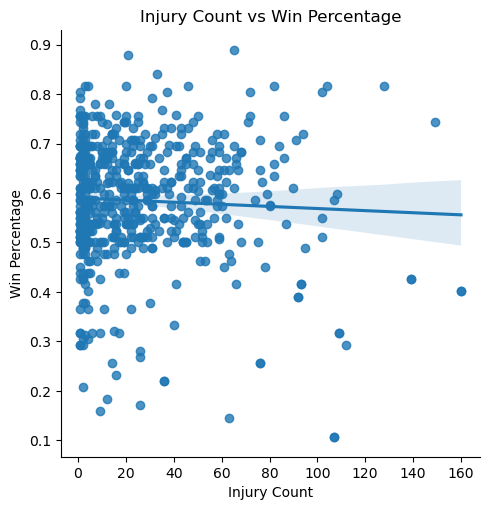

Assumptions:
- Observations are independent across team-season.
- Injury count and win percentage are linearly related.
- Injury count and win percentage are approximately normally distributed (or large sample).
H0: The data is normally distributed.
H1: The data is not normally distrubted.
Assume that alpha=0.05 If p-value is >0.05, it can be said that data is normally distributed.

Normality check for Injury_Count_x:
p value:0.0000
Reject null hypothesis >> The data is not normally distributed
Normality check for W/L%:
p value:0.0000
Reject null hypothesis >> The data is not normally distributed
H0: The variances of the samples are same.
H1: The variances of the samples are different.

It tests the null hypothesis that the population variances are equal.
If the resulting p-value of Levene's test is less than significance level 0.05,
the obtained differences in sample variances are unlikely to have occurred based 
on random sampling from a population with equal variances.

Variance hom

In [ ]:
def plot_injury_vs_win_pct_team(df):
    avg = df.groupby('Team')[['Injury_Count_x','W/L%']].mean().dropna()
    
    plot = sns.lmplot(data=avg, x='Injury_Count_x', y='W/L%')
    plot.set(xlabel='Injury Count', ylabel='Win Percentage', title='Injury Count vs Win Percentage by Team')
    plt.show()

plot_injury_vs_win_pct_team(merged_df)

def plot_injury_vs_win_pct(df):
    df = df.dropna(subset=['Injury_Count_x', 'W/L%'])

    plot = sns.lmplot(data=df, x='Injury_Count_x', y='W/L%')
    plot.set(xlabel='Injury Count', ylabel='Win Percentage', title='Injury Count vs Win Percentage')
    plt.show()

plot_injury_vs_win_pct(merged_df)

def check_normality(data):
    test_stat_normality, p_value_normality=stats.shapiro(data)
    print("p value:%.4f" % p_value_normality)
    if p_value_normality <0.05:
        print("Reject null hypothesis >> The data is not normally distributed")
    else:
        print("Fail to reject null hypothesis >> The data is normally distributed")  
        
def check_variance_homogeneity(group1, group2):
    test_stat_var, p_value_var= stats.levene(group1,group2)
    print("p value:%.4f" % p_value_var)
    if p_value_var <0.05:
        print("Reject null hypothesis >> The variances of the samples are different.")
    else:
        print("Fail to reject null hypothesis >> The variances of the samples are same.")

# 1 Assumptions
print("Assumptions:")
print("- Observations are independent across team-season.")
print("- Injury count and win percentage are linearly related.")
print("- Injury count and win percentage are approximately normally distributed (or large sample")
print()

# 2 Define Variables
df_test = merged_df.dropna(subset=['Injury_Count_x', 'W/L%'])
df_test.describe()
x = df_test['Injury_Count_x']
y = df_test['W/L%']

# 3 Check normality of each variable
print("H0: The data is normally distributed.")
print("H1: The data is not normally distrubted.")
print("Assume that alpha=0.05 If p-value is >0.05, it can be said that data is normally distributed.")
print()
print("Normality check for Injury_Count_x:")
check_normality(x)

print("Normality check for W/L%:")
check_normality(y)

# 4 Check variance of each variable.
print("H0: The variances of the samples are same.")
print("H1: The variances of the samples are different.")
print()
print("""It tests the null hypothesis that the population variances are equal.
If the resulting p-value of Levene's test is less than significance level 0.05,
the obtained differences in sample variances are unlikely to have occurred based 
on random sampling from a population with equal variances.""")
print()
print("Variance homogeneity check (Injury_Count_x vs W/L%):")
check_variance_homogeneity(x, y)

# 5 Hypotheses
print("Hypotheses:")
print("H0: ρ = 0 -> No linear relationship between injury count and win percentage.")
print("H1: ρ != 0 -> Linear relationship exists between injury count and win percentage.")
print()

# 6 Pearson correlation test
r, p_value = pearsonr(x, y)
print(f"Pearson correlation coefficient: r = {r:.3f}")
print(f"p-value = {p_value:.5f}")

alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis -= Evidence of a linear relationship between injury count and win percentage.")
    if r < 0:
        print("Relationship is negative = More injuries tend to correlate with lower win percentage.")
    else:
        print("Relationship is positive = More injuries tend to correlate with higher win percentage.")
else:
    print("Fail to reject null hypothesis = No significant linear relationship detected.")

First, the average injury count and average win percentage for each team over multiple seasons showed a clear negative trend. Teams that averaged higher injury counts across seasons tended to have lower average win percentages. While the slope was not extremely steep, the downward trend was visually noticeable. This aligns with our original hypothesis that injuries negatively impact a team’s success. Interestingly, a few outlier teams maintained high win percentages despite relatively high injury averages, possibly due to roster depth, strategic coaching, or mid-season acquisitions.

To continue, we conducted an analysis on all teams’ seasons from year to year. This plot produced a much weaker downward slope, showing a slight negative trend. This discrepancy between the plots could be due to the season-by-season data being more random and averaging across teams decreasing variability.

Next, we conducted a statistical analysis using the Pearson correlation test to determine the strength of the linear relationship between injury count and win percentage across team seasons. The results were a correlation coefficient of -0.10 and a p-value of 0.12. This shows a very weak negative correlation and the results were not statistically significant, so we failed to reject the null hypothesis. This means there was no strong evidence of a linear relationship between injury count and win percentage across all team seasons.

### 2. Do teams with fewer injuries consistently rank higher in their conferences or make deeper playoff runs?

To investigate this, we visualized the relashionship between injury count and playoff outcome using a box plot, where each playoff ocutcome was plotted against average number of injuries.

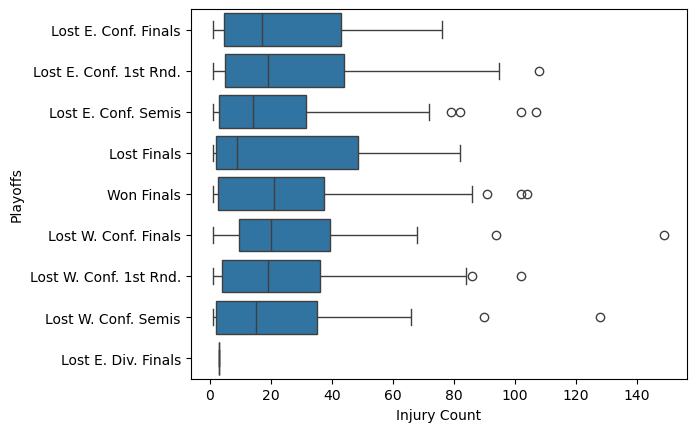

In [9]:
# Plotting for question #2
def plot_injuries_vs_playoff_sucess(df):
    '''
    Takes in merged df and returns boxplot of average injury count for teams that made it to each
    round of the playoffs.
    '''
    df = df.dropna(subset=['Playoffs','Injury_Count_x'])

    plot = sns.boxplot(df, x='Injury_Count_x', y='Playoffs')
    plot = plot.set(xlabel='Injury Count')
    plt.show()

plot_injuries_vs_playoff_sucess(merged_df)

This box plot showed a very slight downward trend in injury as teams advanced further into the playoffs. While this trend is subtle, it aligns with our expectation that teams with fewer injuries perform better in postseason play. One notable exception to the trend is the team that wins Finals generally having the largest injury count. This could be because to reach the Finals, teams have to play a lot of games, oftentimes making their injury counts larger. Additionally, there is still a lot of overlap in the box plot, suggesting other factors must play a role. Some of these factors could be bench depth, timing of injuries, and if starters were injured. Overall, the impact of injuries on playoff performance is likely intertwined with many other factors. Further analysis could explore these factors, looking at injury severity or key player injuries.

### 3. Do teams with stronger strength of schedule suffer more injuries throughout the season?

To analyze this, we plotted each teams injury count over a season vs. strength of schedule. Our initial expectation was that teams with tougher schedules would experience more injuries due to the increased physical demands of tougher opponents.

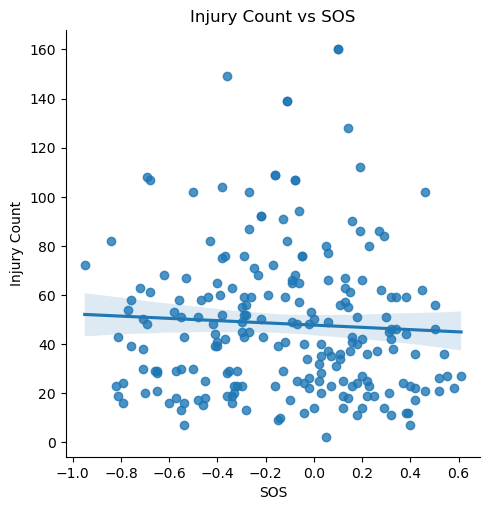

In [10]:
# Plotting for question #3
def plot_injury_vs_sos(df):
    '''
    Takes in merged df and returns scatter plot of injury count vs. strength of schedule for
    NBA teams over the years.
    '''
    df['SOS'] = pd.to_numeric(df['SOS'])
    df = df.dropna(subset=['Injury_Count_x', 'SOS'])

    plot = sns.lmplot(data=df, x='SOS', y='Injury_Count_x')
    plot.set(xlabel='SOS', ylabel='Injury Count', title='Injury Count vs SOS')
    plt.show()

plot_injury_vs_sos(merged_df)

The plot revealed the opposite of what we initially thought. Injury count actually slightly decreased as strength of schedule went up, contradicting our initial hypothesis. A factor that may have contributed to this is that top teams usually play other top teams due to advancing in the playoffs, and may have more depth and resources. Most importantly, the downward slope is not steep and likely insignificant, meaning it’s possible that this pattern is due to other factors. This result highlights the complexity of injuries in sports and suggests that schedule difficulty is probably not the most important factor.

## Implications and Limitations

The strongest beneficiaries of this analysis would be NBA front offices and coaching staff. The analysis highlights relationships between injuries and overall team success. These insights can be a valuable tool in deciding where to allocate resources—for example, load management, training staff, or bench depth. Also, NBA fans could benefit from this analysis, especially sports bettors, allowing them to better understand how injuries can affect win percentage and playoff success.

One group that could be excluded or harmed by this data are players. More injury-prone players could lose contracts or fall out of favor in public perception for “bringing down their team.”

Three limitations of this analysis are inconsistent injury reporting, differences in injury severity, and the fact that injuries are only a fragment of a team’s overall success. To start, our data doesn’t cover seasons before 2000, and even after that, many teams may have underreported injuries due to less rigorous documentation. As a result, it’s unclear how accurate early data is. Additionally, our data doesn’t take into account the severity of injuries and doesn’t differentiate between starters and bench players. A star would likely have a much bigger impact on a team if hurt than a bench player, but this analysis does not account for this. Lastly, injury is just a small piece of a team—other factors, like roster quality, coaching, etc., are not taken into account.

To conclude, much more analysis would need to be done on a variety of factors to determine how impactful injuries are on team performance. This analysis is a good starting ground but should be built on before being used in any professional context.